## Summary: Systematic effects on Edelweiss C

One wonders if a different estimate on the widening necessary for the nuclear-recoil band would happen if there were systematic errors on e.g. the recorded voltage on the detector.

This notebook examines the effect of possible systematics on C.

In [13]:
import numpy as np
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
from scipy import optimize
import lmfit as lmf
import emcee

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

In [14]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

In [15]:
from edelweiss_fit import *

# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

"""yield_data = pd.read_csv("data/edelweiss_avgYeild_GGA1.txt", skiprows=1, \
                       names=['Erecoil', 'Yield', 'Yield_fit_err', 'Yield_err'], \
                       delim_whitespace=True)"""

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}
#yield_data = {'Erecoil': yield_data["Erecoil"][2::], 'Yield': yield_data["Yield"][2::], 'Yield_err': yield_data["Yield_err"][2::]}
#yield_data = {'Erecoil': yield_data["Erecoil"][2::], 'Yield': 0.16*np.power(yield_data["Erecoil"][2::], 0.18), 'Yield_err': 0.01*0.16*np.power(yield_data["Erecoil"][2::], 0.18)}

## Fit with an MCMC method

In [16]:
def log_likelihood(theta, ER_data, NR_data):
    aH, C, m, scale, A, B = theta
    x_ER, y_ER, yerr_ER = ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err']
    x, y, yerr = NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']
    #x_yield, y_yield, yerr_yield = yield_data['Erecoil'], yield_data['Yield'], yield_data['Yield_err']
    
    # expected parameter values and widths
    # scale width estimated by assuming a 10 mV error on V and 0.5 eV error on epsilon
    # information for A and B from Astroparticle Physics 14 (2001) 329±337
    exp_aH = 0.016
    exp_aH_sig = exp_aH*0.046
    exp_scale = 1
    exp_scale_sig = 0.17
    exp_A = 0.16
    exp_A_sig = 0.07
    exp_B = 0.18
    exp_B_sig = 0.1
    
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': A, 'b': B}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    model_ER = sigER_func(x_ER)
    sigma2_ER = yerr_ER**2
    model_NR = sigNR_func(x)
    sigma2_NR = yerr**2
    """    
    model_yield = Q_avg(x_yield, A, B)
    sigma2_yield = yerr_yield**2
    """
    
    return -0.5*(np.sum((y-model_NR)**2/sigma2_NR + np.log(2*np.pi*sigma2_NR)) \
                 + np.sum((y_ER-model_ER)**2/sigma2_ER + np.log(2*np.pi*sigma2_ER)) \
                 + (aH - exp_aH)**2/exp_aH_sig**2 + (scale - exp_scale)**2/exp_scale_sig**2 + (A - exp_A)**2/exp_A_sig**2 + (B - exp_B)**2/exp_B_sig**2)

In [17]:
def gauss_log_prior(theta):
    aH, C, m, scale, A, B = theta
    """    
    scale_sig_sq = 0.5*0.5
    A_sig_sq = (0.07)**2
    B_sig_sq = (0.1)**2
    scale_expected = 1
    A_exp = 0.16
    B_exp = 0.18
    """
    
    if -0.5 < aH < 0.5 and 0.02 < C < 0.05 and -1e-3 < m < 1e-3 and 0 < scale < 100 and 0 < A < 0.3 and 0 < B < 0.3:
        return 0.0 
        #return 0.0 - (scale-scale_expected)**2/(2*scale_sig_sq) - (A - A_exp)**2/(2*A_sig_sq) - (B - B_exp)**2/(2*B_sig_sq)
    return -np.inf

In [18]:
def new_log_probability(theta, ER_data, NR_data, prior_func):
    lp = prior_func(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ER_data, NR_data)

## Find the minimum likelihood

When all six parameters are allowed to vary, the solution finds a small value for A and a larger value for B:

aH, C, m, scale, A, B = x: array([1.42450916e-02, 4.23384048e-02, 1.45366242e-05, 1.17278141e+00,
       5.26524413e-02, 2.84524357e-01])

In [19]:
# start at about the minimum
aH, C, m, scale, A, B = 0.0164, 0.0348, 9.39E-5, 1.0, 0.16, 0.18

from scipy.optimize import minimize
#np.random.seed(42)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([aH, C, m, scale, A, B]) #+ 0.001*np.random.randn(2)
soln = minimize(nll, initial, method='Nelder-Mead', args=(ER_data, NR_data), options={'adaptive':True})

aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit = soln.x
print (soln)

 final_simplex: (array([[1.59557510e-02, 4.01120006e-02, 4.11442471e-05, 1.03493435e+00,
        1.16847345e-01, 1.52032678e-01],
       [1.59555446e-02, 4.01085615e-02, 4.11995529e-05, 1.03492934e+00,
        1.16849803e-01, 1.52096570e-01],
       [1.59556885e-02, 4.01148620e-02, 4.11601467e-05, 1.03492359e+00,
        1.16846001e-01, 1.51945115e-01],
       [1.59546986e-02, 4.01121023e-02, 4.11506754e-05, 1.03497872e+00,
        1.16841331e-01, 1.52029352e-01],
       [1.59554644e-02, 4.01118323e-02, 4.11430575e-05, 1.03493148e+00,
        1.16875051e-01, 1.52032529e-01],
       [1.59552186e-02, 4.01141185e-02, 4.11195080e-05, 1.03497438e+00,
        1.16810140e-01, 1.52084595e-01],
       [1.59549104e-02, 4.01100028e-02, 4.11698153e-05, 1.03499962e+00,
        1.16872927e-01, 1.52014297e-01]]), array([-53.62305136, -53.62305124, -53.62305094, -53.62305093,
       -53.62305085, -53.62305083, -53.62305078]))
           fun: -53.62305135890497
       message: 'Optimization terminated 

In [20]:
Test = False
filename = 'data/edelweiss_C_systematicErrors_sampler_nll_allpars_gausPrior.h5'

# random walks starting near the minimum
ndim, nwalkers = 6, 100

    
if not Test:
    pos = [[aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit] + 1e-8*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, new_log_probability, args=(ER_data, NR_data, gauss_log_prior))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain
    
else:
    f = h5py.File(filename,'r')

    # need to store data in an array:
    # The sampler will now have a chains attribute 
    # which is an array with shape (Nwalker,N,Ndim) 
    # where N is the number of interations (500 in our inital run)
    # and Ndim is the number of fit parameters
    path='{}/{}/'.format('mcmc','sampler')

    aH = np.asarray(f[path+'aH'])
    C = np.asarray(f[path+'C'])
    m = np.asarray(f[path+'m'])
    scale = np.asarray(f[path+'scale'])
    A = np.asarray(f[path+'A'])
    B = np.asarray(f[path+'B'])
    samples = np.asarray(f[path+'samples'])

    f.close()

In [21]:
import os.path

if not Test:
    #save the MCMC results
    path='{}/{}/'.format('mcmc','sampler')

    #remove vars
    f = h5py.File(filename,'a')
    exaH = path+'aH' in f
    exC = path+'C' in f
    exm = path+'m' in f
    exscale = path+'scale' in f
    exA = path+'A' in f
    exB = path+'B' in f
    exsamp = path+'samples' in f

    if exaH:
      del f[path+'aH']
    if exC:
      del f[path+'C']
    if exm:
      del f[path+'m']
    if exscale:
      del f[path+'scale']
    if exA:
      del f[path+'A']
    if exB:
      del f[path+'B']
    if exsamp:
      del f[path+'samples']

    dset = f.create_dataset(path+'aH',np.shape(aH),dtype=np.dtype('float64').type)
    dset[...] = aH
    dset = f.create_dataset(path+'C',np.shape(C),dtype=np.dtype('float64').type)
    dset[...] = C
    dset = f.create_dataset(path+'m',np.shape(m),dtype=np.dtype('float64').type)
    dset[...] = m
    dset = f.create_dataset(path+'scale',np.shape(scale),dtype=np.dtype('float64').type)
    dset[...] = scale
    dset = f.create_dataset(path+'A',np.shape(scale),dtype=np.dtype('float64').type)
    dset[...] = A
    dset = f.create_dataset(path+'B',np.shape(scale),dtype=np.dtype('float64').type)
    dset[...] = B
    dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples

    f.close()

(100, 500, 6)
(100, 500)


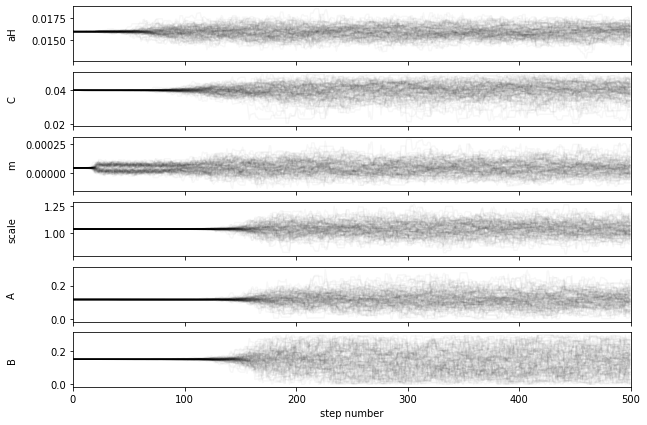

In [22]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

print (np.shape(samples))
print (np.shape(samples[:, :, 1]))
labels = ["aH", "C", "m", "scale", "A", "B"]
for i in range(ndim):
    ax = axes[i]
    # when you pass ax.plot a pair, the columns represent seperate data sets
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.03)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(100, 500, 6)
(20000, 6)


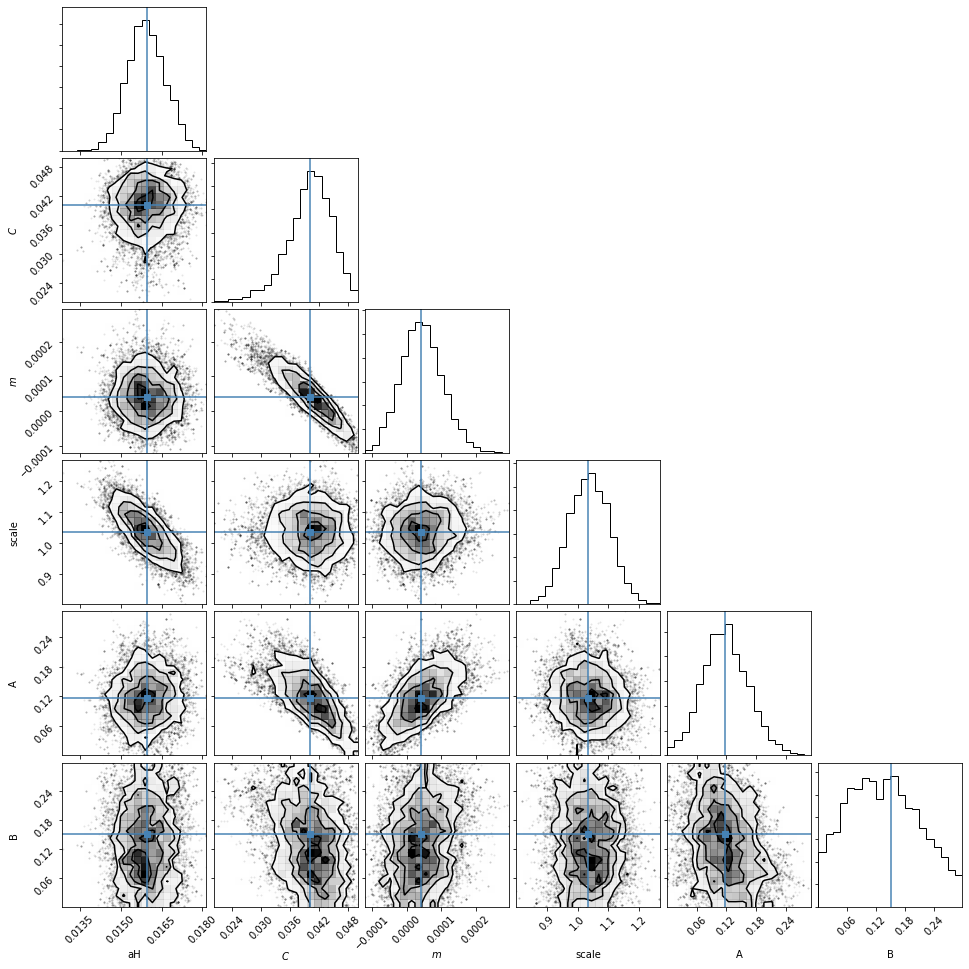

In [23]:
import corner
print(np.shape(samples))
samples = sampler.chain[:, 300:, :].reshape((-1, ndim))
print(np.shape(samples))
fig = corner.corner(samples, labels=["aH", "$C$", "$m$", "scale", "A", "B"],
                      truths=[aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit])

(20000, 6)


(0.04, 0.1)

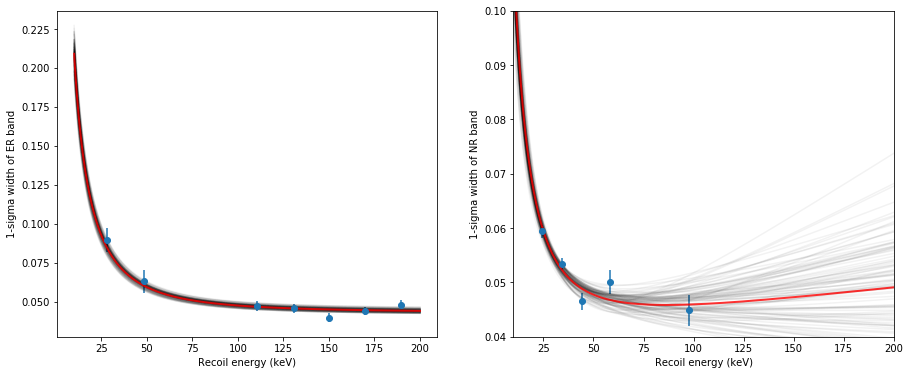

In [24]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
# the ER-band fit
ax1 = axs[0]
ax2 = axs[1]

Erecoil = np.linspace(10, 200, 500)
print(np.shape(samples))
for aH, C, m, scale, A, B in samples[np.random.randint(len(samples), size=100)]:
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': A, 'b': B}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    ax1.plot(Erecoil, sigER_func(Erecoil), color="k", alpha=0.05)
    ax2.plot(Erecoil, sigNR_func(Erecoil), color="k", alpha=0.05)

# plot the best fit
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
par_dict = {'V' : scale_fit*4.0,'eps_eV' : 3.0, 'a': A_fit, 'b': B_fit}

ref_sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                par_dict, aH_fit)
    
ref_sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                  par_dict, aH_fit, C_fit, m_fit)
ax1.plot(Erecoil, ref_sigER_func(Erecoil), color="r", lw=2, alpha=0.8)
ax2.plot(Erecoil, ref_sigNR_func(Erecoil), color="r", lw=2, alpha=0.8)

# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
    
plt.xlim(10, 200)
ax2.set_ylim(0.04, 0.1)

In [ ]:
sampsize=100
evec = np.zeros((np.shape(xl)[0],sampsize))
#print(samples[np.random.randint(len(samples), size=sampsize)])
i=0
for aH, C, m, scale, A, B in samples[np.random.randint(len(samples), size=sampsize)]:
    v = np.sqrt(sigQnr_c_v(xl)**2+(Cms_em+m_em*xl)**2)
    #print(np.std(v))
    #print(np.mean(v))
    cent = np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2)
    evec[:,i] = v
    #print(i)
    #print(np.mean(v)+np.std(v))
    #print(np.mean(v)-np.std(v))
    i=i+1
   
upvec = np.mean(evec,axis=1)+np.std(evec,axis=1)
dnvec = np.mean(evec,axis=1)-np.std(evec,axis=1)

In [ ]:
pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2), color="r", lw=2, alpha=0.8)
pl.plot(xl, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
pl.plot(xl, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)
#pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.xlim(10, 200)
pl.ylim(0.03,0.12)
#args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::],sigQnr_c_v))
pl.errorbar(E_recoil[2::], sig_NR[2::], yerr=sig_NR_err[2::], fmt=".k", capsize=0)